# **HEATMAP TEKS - TOPIK NLP (Natural Language Processing) - KECERDASAN BUATAN**

## Federico Matthew Pratama - 233405001

### Setup dan Import Library yang Dibutuhkan

In [ ]:
# Import library dasar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib
import re
import os
import time
from tqdm.notebook import tqdm

# Natural Language Processing library
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

# Machine Learning library
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Visualisasi
import seaborn as sns
from IPython.display import HTML, display

# Utility untuk memory management
import gc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Download dan Ekstrak Dataset IMDb

In [ ]:
# Download dataset IMDb dari Stanford
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz
!rm -rf aclImdb/train/unsup  # Hapus file yang tidak diperlukan

print("Dataset berhasil diunduh dan diekstrak")

--2025-06-02 03:18:54--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  19.4MB/s    in 7.2s    

2025-06-02 03:19:01 (11.1 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

Dataset berhasil diunduh dan diekstrak


### Load Keseluruhan Dataset

In [ ]:
def load_imdb_data(data_dir, label):
    """
    Fungsi untuk load data dari direktori aclImdb
    """
    texts = []
    labels = []
    dir_path = os.path.join(data_dir, label)
    print(f"Loading {label} reviews from {dir_path}...")

    # Gunakan tqdm untuk progress bar
    filenames = os.listdir(dir_path)
    for fname in tqdm(filenames):
        if fname.endswith('.txt'):
            with open(os.path.join(dir_path, fname), encoding='utf-8') as f:
                texts.append(f.read())
            labels.append(1 if label == 'pos' else 0)
    return texts, labels

# Mulai waktu proses
start_time = time.time()

# Load semua data train
print("Loading training data...")
train_pos_texts, train_pos_labels = load_imdb_data('aclImdb/train', 'pos')
train_neg_texts, train_neg_labels = load_imdb_data('aclImdb/train', 'neg')
train_texts = train_pos_texts + train_neg_texts
train_labels = train_pos_labels + train_neg_labels

# Load semua data test
print("Loading test data...")
test_pos_texts, test_pos_labels = load_imdb_data('aclImdb/test', 'pos')
test_neg_texts, test_neg_labels = load_imdb_data('aclImdb/test', 'neg')
test_texts = test_pos_texts + test_neg_texts
test_labels = test_pos_labels + test_neg_labels

# Waktu proses
process_time = time.time() - start_time
print(f"Data loading completed in {process_time:.2f} seconds")

# Info dataset
print(f"\nTotal training examples: {len(train_texts)}")
print(f"Total testing examples: {len(test_texts)}")
print(f"Positive training examples: {len(train_pos_texts)}")
print(f"Negative training examples: {len(train_neg_texts)}")

Loading training data...
Loading pos reviews from aclImdb/train/pos...


  0%|          | 0/12500 [00:00<?, ?it/s]

Loading neg reviews from aclImdb/train/neg...


  0%|          | 0/12500 [00:00<?, ?it/s]

Loading test data...
Loading pos reviews from aclImdb/test/pos...


  0%|          | 0/12500 [00:00<?, ?it/s]

Loading neg reviews from aclImdb/test/neg...


  0%|          | 0/12500 [00:00<?, ?it/s]

Data loading completed in 1.49 seconds

Total training examples: 25000
Total testing examples: 25000
Positive training examples: 12500
Negative training examples: 12500


### Lihat Contoh Data

In [ ]:
# Melihat contoh review positif dan negatif
print("Contoh review positif:")
print("-" * 50)
print(train_pos_texts[0][:500] + "...\n")

print("Contoh review negatif:")
print("-" * 50)
print(train_neg_texts[0][:500] + "...")

Contoh review positif:
--------------------------------------------------
Listening to the soundtrack at the moment, the images come back with a vividness that makes my longing for a dry eye very strong (in order to be able to type this). I've seen it twice thus far, and I should be ashamed for having seen it *only* twice.<br /><br />I've seen all Miyazaki & Studio Ghibli films, and they are invariably nothing less than masterpieces (except maybe for Nausicaa which was, even in the non-cut up version too premature compared to the nec-plus-ultra manga). Still, their st...

Contoh review negatif:
--------------------------------------------------
This movie was amusing at times, hell sometimes it was even downright funny.<br /><br />The underlying message I got from the film though, was that women are responsible for all of the troubles of man. Every time a woman is depicted in the film, she is being lazy, being slutty or lambasting some poor guy for no apparent reason. I don't think the

### Text Preprocessing

In [ ]:
def preprocess_text(text):
    """
    Fungsi untuk membersihkan dan preprocessing teks
    """
    # Hapus HTML tag
    text = re.sub(r'<.*?>', '', text)
    # Hapus karakter non-alphabet kecuali spasi
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert ke lowercase
    text = text.lower()
    # Hapus stopwords
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Preprocessing seluruh dataset
print("Preprocessing training data...")
start_time = time.time()
preprocessed_train_texts = []
for text in tqdm(train_texts):
    preprocessed_train_texts.append(preprocess_text(text))
process_time = time.time() - start_time
print(f"Preprocessing completed in {process_time:.2f} seconds")

# Preprocessing untuk data test
print("\nPreprocessing testing data...")
start_time = time.time()
preprocessed_test_texts = []
for text in tqdm(test_texts):
    preprocessed_test_texts.append(preprocess_text(text))
process_time = time.time() - start_time
print(f"Preprocessing completed in {process_time:.2f} seconds")

Preprocessing training data...


  0%|          | 0/25000 [00:00<?, ?it/s]

Preprocessing completed in 4.87 seconds

Preprocessing testing data...


  0%|          | 0/25000 [00:00<?, ?it/s]

Preprocessing completed in 5.87 seconds


### Feature Extraction dengan TF-IDF Vectorizer

In [ ]:
# Gunakan TF-IDF untuk ekstraksi fitur (lebih baik untuk heatmap karena mempertimbangkan kepentingan kata)
print("Extracting features with TF-IDF...")
start_time = time.time()

# Ekstraksi fitur dengan parameter untuk optimasi memory
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  # Batasi jumlah fitur untuk menghemat memory
    min_df=5,           # Abaikan kata yang muncul kurang dari 5 dokumen
    max_df=0.8          # Abaikan kata yang muncul lebih dari 80% dokumen
)

# Fit dan transform data training
X_train = tfidf_vectorizer.fit_transform(preprocessed_train_texts)
y_train = train_labels

# Transform data testing
X_test = tfidf_vectorizer.transform(preprocessed_test_texts)
y_test = test_labels

process_time = time.time() - start_time
print(f"Feature extraction completed in {process_time:.2f} seconds")

# Info dimensi data
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")

Extracting features with TF-IDF...
Feature extraction completed in 5.53 seconds
Training features shape: (25000, 10000)
Testing features shape: (25000, 10000)


### Training Model Klasifikasi

In [ ]:
# Train model Logistic Regression dengan parameter untuk optimasi memory dan kecepatan
print("Training Logistic Regression model...")
start_time = time.time()

# Menggunakan solver lbfgs yang lebih cepat untuk dataset besar
log_reg = LogisticRegression(
    C=1.0,
    max_iter=100,
    solver='lbfgs',
    n_jobs=-1,  # Gunakan semua cores
    random_state=42
)

log_reg.fit(X_train, y_train)

process_time = time.time() - start_time
print(f"Model training completed in {process_time:.2f} seconds")

# Evaluasi model
print("\nEvaluating model...")
start_time = time.time()
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Training Logistic Regression model...
Model training completed in 2.05 seconds

Evaluating model...
Accuracy: 0.8811

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



### Analisis Kata-kata Penting

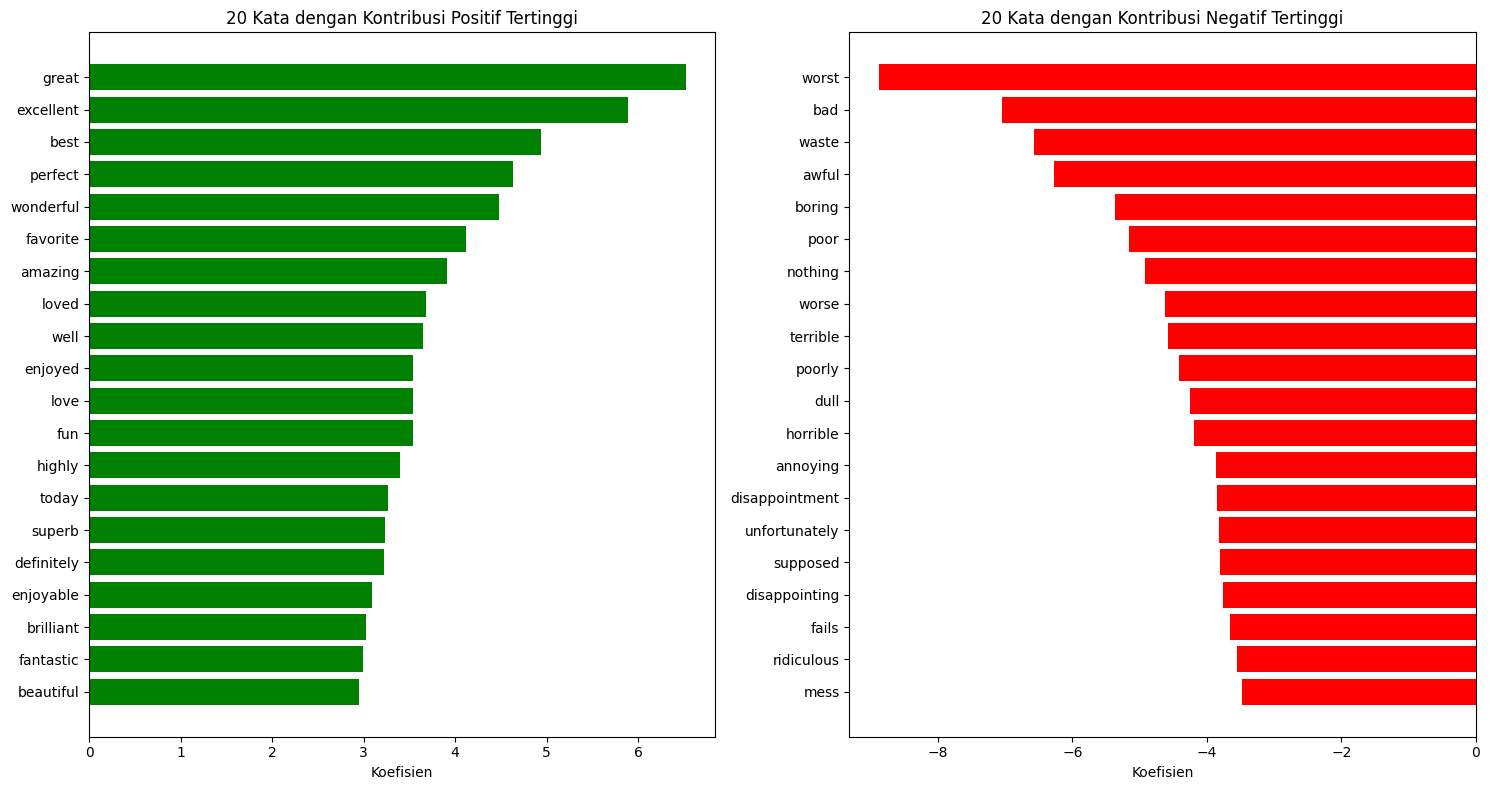

In [ ]:
# Analisis koefisien model untuk mengetahui kata-kata penting
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
coefficients = log_reg.coef_[0]

# 20 kata dengan kontribusi positif tertinggi
top_positive_idx = coefficients.argsort()[-20:][::-1]
top_positive_words = feature_names[top_positive_idx]
top_positive_coeffs = coefficients[top_positive_idx]

# 20 kata dengan kontribusi negatif terkuat
top_negative_idx = coefficients.argsort()[:20]
top_negative_words = feature_names[top_negative_idx]
top_negative_coeffs = coefficients[top_negative_idx]

# Visualisasi kata-kata penting
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.barh(top_positive_words, top_positive_coeffs, color='green')
plt.xlabel('Koefisien')
plt.title('20 Kata dengan Kontribusi Positif Tertinggi')
plt.gca().invert_yaxis()  # Untuk menampilkan kata dengan koefisien tertinggi di atas

plt.subplot(1, 2, 2)
plt.barh(top_negative_words, top_negative_coeffs, color='red')
plt.xlabel('Koefisien')
plt.title('20 Kata dengan Kontribusi Negatif Tertinggi')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# Simpan kata-kata penting untuk visualisasi heatmap
important_words = {
    'positive': top_positive_words.tolist(),
    'negative': top_negative_words.tolist()
}

### Fungsi untuk Membuat Heatmap Teks

In [ ]:
def get_word_importance(text, model, vectorizer):
    """
    Menghitung importance score untuk setiap kata dalam teks
    """
    # Preprocessing text
    processed_text = preprocess_text(text)
    words = processed_text.split()

    # Ambil feature names dan coefficients dari model
    feature_names = vectorizer.get_feature_names_out()
    coefficients = model.coef_[0]

    # Dictionary untuk mapping kata ke importance score
    word_to_imp = {}
    for i, feat in enumerate(feature_names):
        word_to_imp[feat] = coefficients[i]

    # Hitung importance score untuk setiap kata
    word_importance = []
    visible_words = []

    for word in words:
        if word in word_to_imp:
            importance = word_to_imp[word]
            word_importance.append(importance)
            visible_words.append(word)

    return visible_words, word_importance


def plot_text_heatmap(text, model, vectorizer, max_words=100, title="Word Importance Heatmap"):
    # Preprocessing text
    processed_text = preprocess_text(text)

    # Hanya tampilkan maksimal max_words kata
    words = processed_text.split()[:max_words]

    # Ambil importance score untuk setiap kata
    word_importance = []
    feature_names = vectorizer.get_feature_names_out()
    coef = model.coef_[0]
    word_to_coef = {word: coef[i] for i, word in enumerate(feature_names)}

    for word in words:
        if word in word_to_coef:
            word_importance.append(word_to_coef[word])
        else:
            word_importance.append(0)

    # Set up the plot
    plt.figure(figsize=(20, 3))

    # === PERBAIKAN PEWARNAAN DENGAN SKEMA HIJAU-HITAM-MERAH ===
    # Buat custom colormap: Merah (negatif) - Hitam (netral) - Hijau (positif)
    from matplotlib.colors import LinearSegmentedColormap

    # Buat colormap custom
    custom_cmap = LinearSegmentedColormap.from_list(
        'CustomRedBlackGreen',
        [(0.0, 'red'),      # Merah untuk nilai paling negatif
         (0.45, '#800000'),  # Merah gelap mendekati netral
         (0.5, '#303030'),  # Hitam/abu-abu gelap untuk netral
         (0.55, '#006400'),  # Hijau gelap mendekati netral
         (1.0, 'green')],   # Hijau untuk nilai paling positif
        N=256
    )

    # Dapatkan nilai maksimum absolut untuk skala seimbang
    if word_importance:
        abs_max = max(abs(min(word_importance)), abs(max(word_importance)))
        # Nilai untuk normalisasi dari -1 sampai 1
        normalized_scores = [score / abs_max if abs_max > 0 else 0 for score in word_importance]
        # Konversi ke skala 0 sampai 1 untuk colormap (0 = merah, 0.5 = hitam, 1 = hijau)
        cmap_scores = [(score + 1) / 2 for score in normalized_scores]
    else:
        normalized_scores = []
        cmap_scores = []

    # Visualisasi teks dengan color highlighting
    for i, (word, score, cmap_score) in enumerate(zip(words, word_importance, cmap_scores)):
        # Ambil warna dari custom colormap
        color = custom_cmap(cmap_score)

        # Sesuaikan warna teks untuk kontras yang baik
        text_color = 'white' if cmap_score < 0.7 else 'black'

        # Atur alpha (transparansi) berdasarkan kekuatan sentimen
        # Nilai dekat netral akan memiliki alpha lebih rendah
        sentiment_strength = abs(2 * cmap_score - 1)  # 0 untuk netral, 1 untuk sangat positif/negatif
        alpha = 0.4 + 0.5 * sentiment_strength  # Alpha dari 0.4 (netral) sampai 0.9 (kuat)

        plt.text(i, 0, word,
                 color=text_color,
                 ha='center', va='center',
                 fontsize=12,
                 bbox=dict(
                     facecolor=color,
                     alpha=alpha,
                     pad=5,
                     boxstyle='round,pad=0.5'
                 )
                )

    # Konfigurasi plot
    plt.xlim(-1, len(words))
    plt.ylim(-0.5, 0.5)
    plt.title(title, fontsize=15)
    plt.tick_params(axis='both', which='both', length=0)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Tambahkan colorbar dengan skala yang lebih informatif
    import matplotlib as mpl
    norm = mpl.colors.Normalize(vmin=-abs_max if word_importance else -1,
                               vmax=abs_max if word_importance else 1)
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, orientation='horizontal', pad=0.2)
    cbar.set_label('Word Importance (Negatif → Netral → Positif)')

    # Tambahkan penanda untuk nilai penting
    if word_importance:
        abs_max = max(abs(min(word_importance)), abs(max(word_importance)))
        cbar.set_ticks([-abs_max, -abs_max/2, 0, abs_max/2, abs_max])
        cbar.set_ticklabels(['Sangat Negatif', 'Negatif', 'Netral', 'Positif', 'Sangat Positif'])

    plt.tight_layout()
    plt.show()

### Contoh Visualisasi Heatmap dalam Format Tabel

In [ ]:
example_texts = [
    "Machine learning is a branch of artificial intelligence that focuses on data-based models.",
    "Deep learning networks require significant computational resources.",
    "Sentiment analysis can detect emotions and opinions in text data.",
    "Natural language processing enables computers to understand human language."
]

highlight_words = [
    ["machine learning", "artificial intelligence", "data"],
    ["deep learning", "computational"],
    ["sentiment analysis", "emotions", "opinions"],
    ["natural language processing", "computers", "human language"]
]

def create_manual_heatmap():
    html = """
    <style>
    .heatmap-table {
        border-collapse: collapse;
        width: 100%;
        margin-bottom: 20px;
    }
    .heatmap-table th, .heatmap-table td {
        border: 1px solid #ddd;
        padding: 12px;
        text-align: left;
    }
    .heatmap-table th {
        background-color: #f2f2f2;
    }
    .highlight-negative {
        background-color: #ff0000;
        color: white;
        padding: 2px 4px;
        border-radius: 3px;
    }
    .highlight-neutral {
        background-color: #303030;
        color: white;
        padding: 2px 4px;
        border-radius: 3px;
    }
    .highlight-positive {
        background-color: #008000;
        color: white;
        padding: 2px 4px;
        border-radius: 3px;
    }
    </style>
    <table class="heatmap-table">
        <tr>
            <th>Text with Highlights</th>
            <th>Description</th>
        </tr>
    """

    descriptions = ["Definition, Examples", "Definition", "Effects", "Property, Reasoning"]

    for i, (text, highlight_list, desc) in enumerate(zip(example_texts, highlight_words, descriptions)):
        highlighted_text = text
        for word in highlight_list:

            pattern = r'\b' + re.escape(word) + r'\b'

            highlight_class = "highlight"

            if i % 3 == 0:
                highlight_class = "highlight-negative"  # Merah
            elif i % 3 == 1:
                highlight_class = "highlight-neutral"   # Hitam
            else:
                highlight_class = "highlight-positive"  # Hijau

            replacement = f'<span class="{highlight_class}">{word}</span>'
            highlighted_text = re.sub(pattern, replacement, highlighted_text, flags=re.IGNORECASE)

        html += f"""
        <tr>
            <td>{highlighted_text}</td>
            <td>{desc}</td>
        </tr>
        """

    html += "</table>"
    return HTML(html)

display(create_manual_heatmap())

Text with Highlights,Description
machine learning is a branch of artificial intelligence that focuses on data-based models.,"Definition, Examples"
deep learning networks require significant computational resources.,Definition
sentiment analysis can detect emotions and opinions in text data.,Effects
natural language processing enables computers to understand human language.,"Property, Reasoning"


### Visualisasi Heatmap pada Dataset IMDb

In [ ]:
def create_imdb_heatmap_table():
    """
    Membuat visualisasi heatmap teks dalam bentuk tabel menggunakan data review
    IMDb, dengan memanfaatkan fungsi get_word_importance()
    """
    from IPython.display import HTML
    import re

    # Ambil beberapa review IMDb dengan review yang lebih jelas sentimen-nya
    review_indices = [10, 137, 12537, 12600]  # 2 positif, 2 negatif

    # Pendek-pendekkan review untuk tampilan yang lebih baik
    reviews = []
    labels = []
    for idx in review_indices:
        text = train_texts[idx]
        # Ambil 1-2 kalimat saja
        sentences = re.split(r'[.!?]', text)
        short_review = '. '.join(sentences[:2]) + '.'
        reviews.append(short_review)
        labels.append('Positif' if train_labels[idx] == 1 else 'Negatif')

    # Temukan kata-kata penting untuk di-highlight
    highlight_words = []
    highlight_scores = []  # Menyimpan skor untuk menentukan warna

    for i, idx in enumerate(review_indices):
        # Gunakan fungsi get_word_importance untuk mendapatkan kata-kata penting dan skor mereka
        visible_words, word_importance = get_word_importance(train_texts[idx], log_reg, tfidf_vectorizer)

        # Buat pasangan kata dan skor
        word_scores = [(word, score) for word, score in zip(visible_words, word_importance)]

        # Urutkan berdasarkan nilai absolut dan ambil 5 teratas
        sorted_words = sorted(word_scores, key=lambda x: abs(x[1]), reverse=True)

        # Pastikan minimal 1 kata di-highlight di setiap review
        top_words = [word for word, score in sorted_words[:5] if abs(score) > 0.01]
        top_scores = [score for word, score in sorted_words[:5] if abs(score) > 0.01]

        # Jika tidak ada kata yang memiliki skor di atas threshold, ambil kata dengan skor tertinggi
        if not top_words and sorted_words:
            top_words = [sorted_words[0][0]]
            top_scores = [sorted_words[0][1]]

        highlight_words.append(top_words)
        highlight_scores.append(top_scores)

    # Membuat HTML untuk tabel
    html = """
    <style>
    .heatmap-table {
        border-collapse: collapse;
        width: 100%;
        margin-bottom: 20px;
        font-family: Arial, sans-serif;
    }
    .heatmap-table th, .heatmap-table td {
        border: 1px solid #ddd;
        padding: 12px;
        text-align: left;
    }
    .heatmap-table th {
        background-color: #f2f2f2;
    }
    .highlight-negative {
        background-color: #ff0000;
        color: white;
        padding: 2px 4px;
        border-radius: 3px;
    }
    .highlight-neutral {
        background-color: #303030;
        color: white;
        padding: 2px 4px;
        border-radius: 3px;
    }
    .highlight-positive {
        background-color: #008000;
        color: white;
        padding: 2px 4px;
        border-radius: 3px;
    }
    </style>
    <table class="heatmap-table">
        <tr>
            <th>Review Text with Highlights</th>
            <th>Sentiment</th>
        </tr>
    """

    for i, (review, label, words_to_highlight, scores) in enumerate(zip(reviews, labels, highlight_words, highlight_scores)):
        highlighted_text = review
        for word, score in zip(words_to_highlight, scores):
            # Pilih kelas highlight berdasarkan nilai sentimen
            if score < -0.1:  # Negatif
                highlight_class = "highlight-negative"
            elif score > 0.1:  # Positif
                highlight_class = "highlight-positive"
            else:  # Netral
                highlight_class = "highlight-neutral"

            # Case insensitive replacement with regex
            pattern = r'\b' + re.escape(word) + r'\b'
            replacement = f'<span class="{highlight_class}">{word}</span>'
            highlighted_text = re.sub(pattern, replacement, highlighted_text, flags=re.IGNORECASE)

        html += f"""
        <tr>
            <td>{highlighted_text}</td>
            <td>{label}</td>
        </tr>
        """

    html += "</table>"
    return HTML(html)

# Untuk menjalankan fungsi dan menampilkan tabel heatmap
create_imdb_heatmap_table()

Review Text with Highlights,Sentiment
I finally got around to seeing this after hearing great things about it. It actually exceeded my expectations.,Positif
"I gotta say, Clive Barker's Undying is by far the best horror game to have ever been made. I've played Resident Evil, Silent Hill and the Evil Dead and Castlevania games but none of them have captured the pure glee with which this game tackles its horrific elements.",Positif
"Maybe I've seen one too many crime flick, or maybe I don't take the right drugs. This was the most cliché ridden, plot deficient, plot-absurd, just plain stupid movie I have seen in a long time.",Negatif
"weak Bobby ""Pineapple Salsa"" Flay and Mario Batali bring this down. Flay being the worst.",Negatif
